# Data Science Unit 4 Sprint Challenge 1 — Tree Ensembles

### Chicago Food Inspections

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 1, 2010 to the present. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to load the data:

In [58]:
import pandas as pd
import numpy as np
import category_encoders as ce
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from collections import defaultdict
plt.style.use('dark_background')

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url).sample(2**13)
test  = pd.read_csv(test_url).sample(2**12)

X_train_0 = train.drop(['Fail'], axis=1)
X_test_0 = test.drop(['Fail'], axis=1)
y_train = train.Fail
y_test = test.Fail

#assert train.shape == (51916, 17)
#assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. You may use any tools and techniques for categorical encoding. (Pandas, category_encoders, sklearn.preprocessing, or any other library.)

_To earn a score of 3 for this part, engineer new features, and use any alternative categorical encoding instead of One-Hot or Ordinal/Label encoding._

### Part 2: Modeling

Fit a Random Forest or Gradient Boosting model with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation to estimate an ROC AUC validation score.

Use your model to predict probabilities for the test set. Get an ROC AUC test score >= 0.60.

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70._


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:
- Feature Importances
- Permutation Importances
- Partial Dependence Plot

_To earn a score of 3 for this part, make at least two of these visualization types._

In [59]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
5437,1490838,MARAVILLAS RESTAURANT,MARAVILLAS RESTAURANT,1948652.0,Restaurant,Risk 1 (High),5506 S LAKE PARK AVE,CHICAGO,IL,60637.0,2014-07-22T00:00:00,Complaint,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",41.794934,-87.587736,"{'longitude': '-87.58773625841167', 'latitude'...",0
32634,1970817,CULLINAN'S STADIUM CLUB,CULLINAN'S STADIUM CLUB,34135.0,Restaurant,Risk 2 (Medium),11610 S WESTERN AVE,CHICAGO,IL,60643.0,2016-11-03T00:00:00,Canvass,2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...,41.682344,-87.681008,"{'longitude': '-87.68100795347009', 'latitude'...",1
30130,1361210,West Town Deli,Rosie's West Town Deli,2269688.0,Restaurant,Risk 1 (High),1021 N Western AVE,CHICAGO,IL,60622.0,2013-07-10T00:00:00,License Re-Inspection,"11. ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, D...",41.900112,-87.686810,"{'longitude': '-87.68680973097231', 'latitude'...",1
38267,1537925,SNAP KITCHEN,SNAP KITCHEN,2386172.0,Restaurant,Risk 3 (Low),621 W DIVERSEY PKWY,CHICAGO,IL,60614.0,2015-05-12T00:00:00,License,NaN,41.932699,-87.644491,"{'longitude': '-87.64449072110678', 'latitude'...",0
12151,1170447,HOME OF LIFE COMM. DEV. DAYCAR,HOME OF LIFE COMM. DEV. DAYCAR,54257.0,Daycare (2 - 6 Years),Risk 1 (High),4647 W WASHINGTON BLVD,CHICAGO,IL,60644.0,2012-08-30T00:00:00,Canvass Re-Inspection,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",41.881745,-87.742033,"{'longitude': '-87.74203272034268', 'latitude'...",0


In [60]:
train.dtypes

Inspection ID        int64
DBA Name            object
AKA Name            object
License #          float64
Facility Type       object
Risk                object
Address             object
City                object
State               object
Zip                float64
Inspection Date     object
Inspection Type     object
Violations          object
Latitude           float64
Longitude          float64
Location            object
Fail                 int64
dtype: object

In [61]:
train.describe()

,Inspection ID,License #,Zip,Latitude,Longitude,Fail
count,8.192000e+03,8.192000e+03,8184.000000,8159.000000,8159.000000,8192.000000
mean,1.322768e+06,1.533577e+06,60629.224829,41.878899,-87.677516,0.255981
std,6.234862e+05,9.041898e+05,21.088538,0.081391,0.060780,0.436438
min,4.821300e+04,0.000000e+00,60153.000000,41.646371,-87.914428,0.000000
25%,6.706635e+05,1.118822e+06,60614.000000,41.823420,-87.708643,0.000000
50%,1.418399e+06,1.937266e+06,60625.000000,41.888742,-87.666166,0.000000
75%,1.938056e+06,2.207025e+06,60643.000000,41.938980,-87.634423,1.000000
max,2.279526e+06,3.760532e+06,60827.000000,42.021064,-87.525872,1.000000


In [62]:
X_train_0.isna().sum()

Inspection ID         0
DBA Name              0
AKA Name             83
License #             0
Facility Type        39
Risk                  2
Address               0
City                  9
State                 0
Zip                   8
Inspection Date       0
Inspection Type       0
Violations         1519
Latitude             33
Longitude            33
Location             33
dtype: int64

In [63]:
todrop1 = ['Inspection ID', 'AKA Name', 'License #', 'Location']

def wrangle(dat): 
    import datetime as dt
    assigns = {
        **{'Violations': dat.Violations.fillna('NO_VIOLATIONS'), 
          'Facility Type': dat['Facility Type'].fillna('NOT_APPLICABLE'), 
          'Inspection Date': pd.to_datetime(dat['Inspection Date'], 
                                            infer_datetime_format=True
                                           ).apply(dt.datetime.toordinal)}, 
        **{l: dat[l].fillna(dat[l].mean()) for l in ['Latitude', 'Longitude']}
    }
    
    return dat.assign(**assigns).drop(todrop1, axis=1)

X_train_ = wrangle(X_train_0)
X_test_ = wrangle(X_test_0)

In [64]:
X_train_.isna().sum()

DBA Name           0
Facility Type      0
Risk               2
Address            0
City               9
State              0
Zip                8
Inspection Date    0
Inspection Type    0
Violations         0
Latitude           0
Longitude          0
dtype: int64

In [65]:
print(f'The target is unbalanced target by a factor of {y_train.value_counts()[0] / y_train.value_counts()[1]} favoring `0`. \n\n')

cats = X_train_.select_dtypes(include='object').columns
nums = X_train_.select_dtypes(exclude='object').columns

print(f"We have {len(cats)} categoricals and {len(nums)} numerics. \n")

cards = {n: X_train_[n].value_counts().shape[0] for n in cats}

def report_cards(c): 
    l = [f"\tFeature {k} has cardinality {v}. " for k,v in c.items()]
    return '\n'.join(l)

print(report_cards(cards))

The target is unbalanced target by a factor of 2.9065331425846446 favoring `0`. 


We have 8 categoricals and 4 numerics. 

	Feature DBA Name has cardinality 5899. 
	Feature Facility Type has cardinality 132. 
	Feature Risk has cardinality 3. 
	Feature Address has cardinality 5747. 
	Feature City has cardinality 12. 
	Feature State has cardinality 1. 
	Feature Inspection Type has cardinality 24. 
	Feature Violations has cardinality 6670. 


In [66]:
## We're going to encode "high" and "low" cardinality featuers differently, depending on some meaning of "high"/"low"

thresh=2**12
low = [k for k in cards.keys() if cards[k]<=thresh]
high = [k for k in cards.keys() if cards[k]>thresh]

assert len(low) + len(high) == len(cards.keys())

# send lows to binary encoder and send highs to target encoder. 
low, high

(['Facility Type', 'Risk', 'City', 'State', 'Inspection Type'],
 ['DBA Name', 'Address', 'Violations'])

In [67]:
def encode(train_dat, test_dat, low=low, high=high, targ=y_train, n=4): 
    '''
    base2 encode low cardinality, target encode high cardinailty
    
    Having given up on Target encoding because of `IndexingError: 
        Unalignable boolean Series provided as indexer`, 
    we shall basen encode even the high cardinality ones.   
    
    
    DO NOT RUN THIS. It crashes the computer. 
        #plt.plot(x=list(range(1,10)), y=[encode(X_train[cats], n=k) for k in range(1,10)])
    '''
    assert [x=='object' for x in train_dat.dtypes]
    assert [x=='object' for x in test_dat.dtypes]
    assert all([x==y for x,y in zip(X_train_[high].index, y_train.index)])
    
    bl = ce.basen.BaseNEncoder(base=n, return_df=True)
    #th = ce.TargetEncoder()
    
    bl.fit(train_dat[low+high])
    #bl_df = bl.fit_transform(train_dat[low+high])
    #th_df = th.fit_transform(dat[high], targ, return_df=True)
    
    td = bl.transform(train_dat[low+high])
    print(f"Now is {td.shape[1]} really too many columns?")
    return {'train': td, 'test': bl.transform(test_dat[low+high])}


In [68]:
# cats_dfs = encode(X_train_[cats], X_test_[cats])
# X_train = pd.concat([X_train_[nums], cats_dfs['train']], axis=1, sort=False)
# X_test = pd.concat([X_test_[nums], cats_dfs['test']], axis=1, sort=False)

# X_train.head()

In [69]:
# dtrain = xgb.DMatrix(X_train.values, y_train.values)
# dtest = xgb.DMatrix(X_test.values) 

# # specify parameters via map
# param = {'booster': 'dart',
#          'max_depth': 5, 'learning_rate': 0.1,
#          'objective': 'binary:logistic', 
#          'silent': True,
#          'sample_type': 'uniform',
#          'normalize_type': 'tree',
#          'rate_drop': 0.1,
#          'skip_drop': 0.5}

# num_round = 50
# bst = xgb.train(param, dtrain, num_round)
# # make prediction
# # ntree_limit must not be 0
# preds = bst.predict(dtest, ntree_limit=num_round)

# preds_df = pd.DataFrame({'id': X_test.index, 'failure': preds})
# #preds_df.head()

# roc_auc_score(y_test, preds_df['failure'])

In [70]:
def make_dmats(train=X_train_, test=X_test_, n=3): 
    cats_dfs = encode(train[cats], test[cats], n=n)
    X_train = pd.concat([train[nums], cats_dfs['train']], axis=1, sort=False)
    X_test = pd.concat([test[nums], cats_dfs['test']], axis=1, sort=False)
    
    dtrain = xgb.DMatrix(X_train.values, y_train.values)
    dtest = xgb.DMatrix(X_test.values) 

    return dtrain, dtest

def dart_score(dtrain, dtest, max_depth=5): 
    '''run a dart model and return roc_auc score '''
    
    # specify parameters via map
    param = {'booster': 'dart',
             'max_depth': max_depth, 
             'learning_rate': 0.1,
             'objective': 'binary:logistic', 
             'silent': True,
             'sample_type': 'uniform',
             'normalize_type': 'tree',
             'rate_drop': 0.1,
             'skip_drop': 0.5}

    num_round = 50
    bst = xgb.train(param, dtrain, num_round)
    # make prediction
    # ntree_limit must not be 0
    preds = bst.predict(dtest, ntree_limit=num_round)

    preds_df = pd.DataFrame({'id': X_test_.index, 'failure': preds})

    return roc_auc_score(y_test, preds_df['failure'])

def vanilla_boost_score(dtrain, dtest, max_depth=2, eta=0.8):
    # specify parameters via map
    param = {'max_depth': max_depth, 
             'eta': eta, 
             'silent':1, 
             'objective':'binary:logistic' }
    num_round = 2
    bst = xgb.train(param, dtrain, num_round)
    # make prediction
    preds = bst.predict(dtest)
    preds_df = pd.DataFrame({'id': X_test_.index, 'failure': preds})
    return roc_auc_score(y_test, preds_df['failure'])

dart_choices_n_coder_rocauc = {}
vani_choices_n_coder_rocauc = {}
for k in [2,3,4,5,6,7,8]:
    dmats = make_dmats(n=k)
    dart_choices_n_coder_rocauc[k] = dart_score(dmats[0], dmats[1])
    #vani_choices_n_coder_rocauc[k] = vanilla_boost_score(dmats[0], dmats[1])

dart_choices_n_coder_rocauc#, vani_choices_n_coder_rocauc

Now is 66 really too many columns?
Now is 46 really too many columns?
Now is 39 really too many columns?
Now is 35 really too many columns?
Now is 31 really too many columns?
Now is 31 really too many columns?
Now is 31 really too many columns?


{2: 0.6769402691816485,
 3: 0.6701333628057767,
 4: 0.6510890988800472,
 5: 0.6732322674133019,
 6: 0.6288522939385008,
 7: 0.6514636445132135,
 8: 0.6465352993909028}

In [71]:
# The dart at n=2 is the best, it appears. 


### Part 3: Visualization

Make one visualization for model interpretation. (You may use any libraries.) Choose one of these types:
- Feature Importances
- Permutation Importances
- Partial Dependence Plot

_To earn a score of 3 for this part, make at least two of these visualization types._

In [72]:
# from eli5.xgboost import explain_prediction_xgboost
# from eli5 import show_weights

# from xgboost import XGBClassifier
# from sklearn.feature_extraction import DictVectorizer
# from sklearn.pipeline import make_pipeline
# from sklearn.model_selection import cross_val_score

# clf = XGBClassifier()
# vec = DictVectorizer()
# pipeline = make_pipeline(vec, clf)

# def evaluate(_clf):
#     scores = cross_val_score(_clf, all_xs, all_ys, scoring='accuracy', cv=10)
#     print('Accuracy: {:.3f} ± {:.3f}'.format(np.mean(scores), 2 * np.std(scores)))
#     _clf.fit(train_xs, train_ys)  # so that parts of the original pipeline are fitted

# evaluate(pipeline)


# def dart(dtrain, dtest, max_depth=5): 
#     '''run a dart model and return bst object '''
    
#     # specify parameters via map
#     param = {'booster': 'dart',
#              'max_depth': max_depth, 
#              'learning_rate': 0.1,
#              'objective': 'binary:logistic', 
#              'silent': True,
#              'sample_type': 'uniform',
#              'normalize_type': 'tree',
#              'rate_drop': 0.1,
#              'skip_drop': 0.5}

#     num_round = 50
#     bst = xgb.train(param, dtrain, num_round)
# #     # make prediction
# #     # ntree_limit must not be 0
# #     preds = bst.predict(dtest, ntree_limit=num_round)

# #     preds_df = pd.DataFrame({'id': X_test_.index, 'failure': preds})

#     return bst # roc_auc_score(y_test, preds_df['failure'])



In [73]:
# dmats = make_dmats(n=2)
# #explain_prediction_xgboost(dart(dmats[0], dmats[1]), doc=)

# pipeline=make_pipeline(vec, dart(dmats[0], dmats[1]))

# evaluate(pipeline)

In [74]:
#help(explain_prediction_xgboost)

Now is 66 really too many columns?


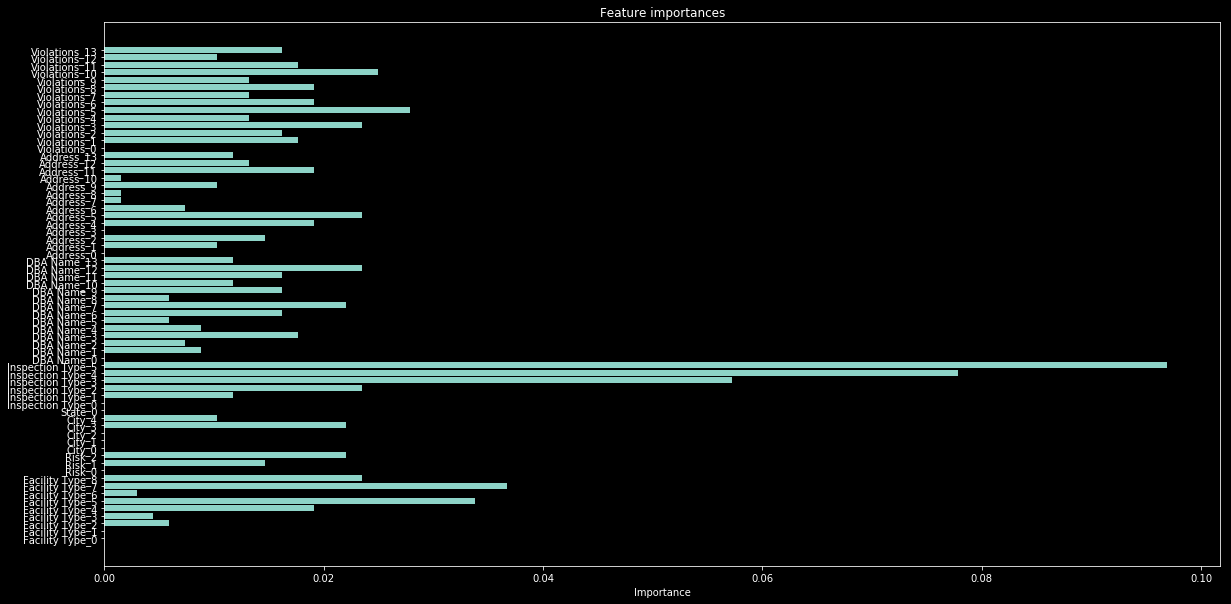

In [75]:
try_ns = [2,7, 5]

def show_importances(n=2):

    cats_dfs = encode(X_train_[cats], X_test_[cats], n=n)

    mod = xgb.XGBClassifier()

    mod.fit(cats_dfs['train'], y_train)

    importances = mod.feature_importances_
    names = cats_dfs['train'].columns
    y_pos = np.arange(len(names))
    
    fig, ax = plt.subplots(figsize=(20,10))

    ax.barh(y_pos, importances, align='center')
    #ax.set_xticks(min(importances), max(importances))
    ax.set_yticks(y_pos)
    ax.set_yticklabels(names)
    ax.set_xlabel('Importance')
    ax.set_title('Feature importances')
    

    plt.show;
    pass

show_importances()

Now is 31 really too many columns?


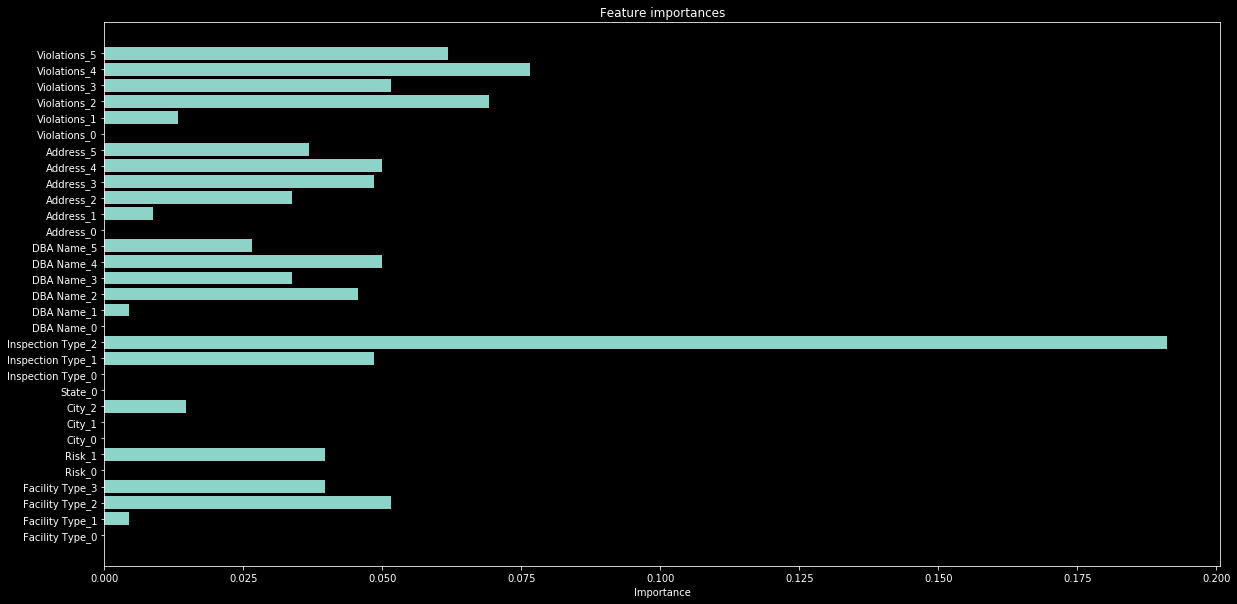

In [76]:
show_importances(n=7)

In [ ]:
show_importances(n=5)

# TLDR: 
Inspection type is the most important feature! 


## Now lets run all this again, this time without _sampling down_ to smaller data, and compare. 

In [77]:
train = pd.read_csv(train_url)#.sample(2**13)
test  = pd.read_csv(test_url)#.sample(2**12)

X_train_0 = train.drop(['Fail'], axis=1)
X_test_0 = test.drop(['Fail'], axis=1)
y_train = train.Fail
y_test = test.Fail

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

X_train_ = wrangle(X_train_0)
X_test_ = wrangle(X_test_0)


dart_choices_n_coder_rocauc = {}
vani_choices_n_coder_rocauc = {}
for k in [2,3,4,5,6,7,8]:
    dmats = make_dmats(n=k)
    dart_choices_n_coder_rocauc[k] = dart_score(dmats[0], dmats[1])
    #vani_choices_n_coder_rocauc[k] = vanilla_boost_score(dmats[0], dmats[1])

print(dart_choices_n_coder_rocauc)#, vani_choices_n_coder_rocauc

Now is 66 really too many columns?


XGBoostError: b'[13:55:50] src/objective/regression_obj.cu:66: Check failed: preds.Size() == info.labels_.Size() (8192 vs. 51916) labels are not correctly providedpreds.size=8192, label.size=51916\n\nStack trace returned 10 entries:\n[bt] (0) /home/quinn/anaconda3/lib/libxgboost.so(dmlc::StackTrace[abi:cxx11]()+0x55) [0x7f0d173e73b5]\n[bt] (1) /home/quinn/anaconda3/lib/libxgboost.so(dmlc::LogMessageFatal::~LogMessageFatal()+0x3b) [0x7f0d173e7bab]\n[bt] (2) /home/quinn/anaconda3/lib/libxgboost.so(xgboost::obj::RegLossObj<xgboost::obj::LogisticClassification>::GetGradient(xgboost::HostDeviceVector<float> const&, xgboost::MetaInfo const&, int, xgboost::HostDeviceVector<xgboost::detail::GradientPairInternal<float> >*)+0x211) [0x7f0d1749b891]\n[bt] (3) /home/quinn/anaconda3/lib/libxgboost.so(xgboost::LearnerImpl::UpdateOneIter(int, xgboost::DMatrix*)+0x1dc) [0x7f0d173f35bc]\n[bt] (4) /home/quinn/anaconda3/lib/libxgboost.so(XGBoosterUpdateOneIter+0x48) [0x7f0d17571ac8]\n[bt] (5) /home/quinn/anaconda3/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call_unix64+0x4c) [0x7f0d48809630]\n[bt] (6) /home/quinn/anaconda3/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call+0x22d) [0x7f0d48808fed]\n[bt] (7) /home/quinn/anaconda3/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(_ctypes_callproc+0x2ce) [0x7f0d47ab000e]\n[bt] (8) /home/quinn/anaconda3/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(+0x13a45) [0x7f0d47ab0a45]\n[bt] (9) /home/quinn/anaconda3/bin/python(_PyObject_FastCallDict+0x8b) [0x56466e48fd2b]\n\n'

In [ ]:
show_importances(2)

In [ ]:
show_importances(7)